In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from tensorflow import keras
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

In [2]:
def save_images(predictions, save_dir, cancer_type):

    for i in range(predictions.shape[0]):

        plt.imshow(predictions[i])
        plt.axis('off')
        plt.savefig(os.path.join(save_dir,'gan_image_{}_{:04d}.png'.format(cancer_type, i))) 
        plt.close()

    return 'Finished!'

## Global Variables

In [3]:
LATENT_DIM = 32
NUMBER_OF_IMAGES = 16
CHANNELS = 3
LATENT_VECTORS = np.random.normal(size = (NUMBER_OF_IMAGES, LATENT_DIM)) / 2

## Generator

In [4]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [5]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

## Adenosis

In [6]:
save_dir_adenosis = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Gan_Images/benign/adenosis/'

In [7]:
# Load checkpoint model
model_path_adenosis = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Saved_Checkpoints/100k_epochs/cps_100k/100k_adenosis/generator_model_16000_100k.h5'
generator_adenosis = tf.keras.models.load_model(model_path_adenosis, compile = False)

In [8]:
# Create predictions
predictions_adenosis = generator_adenosis.predict(LATENT_VECTORS)

1/1 [==============================] - 12s 12s/step


In [9]:
save_images(predictions_adenosis, save_dir_adenosis, 'adenosis')

'Finished!'

## Phyllode

In [10]:
save_dir_phyllode = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Gan_Images/bengin/phyllode_carcinoma/'

In [ ]:
# Load checkpoint model
model_path_phyllode = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Saved_Checkpoints/100k_epochs/cps_100k/100k_phyllodes/generator_model_60000.h5'
generator_phyllode = tf.keras.models.load_model(model_path_phyllode, compile = False)

In [ ]:
# Create predictions
predictions_phyllode = generator_phyllode.predict(LATENT_VECTORS)

In [ ]:
save_images(predictions_phyllode, save_dir_phyllode, 'phyllode')

## Lobular

In [13]:
save_dir_lobular = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Gan_Images/malignant/lobular_carcinoma/'

In [14]:
# Load checkpoint model
model_path_lobular = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Saved_Checkpoints/100k_epochs/cps_100k/100k_lobular/generator_model_60000.h5'
generator_lobular = tf.keras.models.load_model(model_path_lobular, compile = False)

In [15]:
# Create predictions
predictions_lobular = generator_lobular.predict(LATENT_VECTORS)

1/1 [==============================] - 12s 12s/step


In [16]:
save_images(predictions_lobular, save_dir_lobular, 'lobular')

'Finished!'

## Papillary

In [ ]:
save_dir_papillary = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Gan_Images/malignant/papillary_carcinoma/'

In [ ]:
# Load checkpoint model
model_path_papillary = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/Saved_Checkpoints/100k_epochs/cps_100k/100k_papillary/generator_model_60000.h5'
generator_papillary = tf.keras.models.load_model(model_path_papillary, compile = False)

In [ ]:
# Create predictions
predictions_papillary = generator_papillary.predict(LATENT_VECTORS)

In [ ]:
save_images(predictions_papillary, save_dir_papillary, 'papillary')

## Frechet Inception Distance Score (FID-Score)

In [17]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

In [28]:
# load original data
def get_all_images(path, resize_param):

    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert("L"))

    for image in os.listdir(path):

        img = cv2.imread(path + image)

        img = cv2.resize(img, (resize_param, resize_param))

        images.append(np.array(img))

    return images

In [29]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):

    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
        # calculate score
        fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [30]:
path_original_adenosis = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/benign/adenosis/'
path_original_phyllode = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/benign/phyllodes_tumor/'
path_original_lobular = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/malignant/lobular_carcinoma/'
path_original_papillary = 'D:/Medical_Imaging/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/malignant/papillary_carcinoma/'

In [31]:
original_adenosis = numpy.array(get_all_images(path_original_adenosis, 128))
original_phyllode = get_all_images(path_original_phyllode, 128)  
original_lobular = numpy.array(get_all_images(path_original_lobular, 128))
original_papillary = get_all_images(path_original_papillary, 128)

In [32]:
# prepare the inception v3 model
model = InceptionV3(include_top = False, pooling = 'avg', input_shape = (128, 128, 3))

In [33]:
# pre-process images
images1_adenosis = preprocess_input(predictions_adenosis)
images2_adenosis = preprocess_input(original_adenosis)

# calculate fid adenosis
fid_adenosis = calculate_fid(model, images1_adenosis, images2_adenosis)
print('FID Adenosis: %.3f' % fid_adenosis)

4/4 [==============================] - 1s 171ms/step
FID Adenosis: 3612.516


In [ ]:
# pre-process images
images1_phyllode = preprocess_input(predictions_phyllode)
images2_phyllode = preprocess_input(original_phyllode)

# calculate fid adenosis
fid_phyllode = calculate_fid(model, images1_phyllode, images2_phyllode)
print('FID Phyllode: %.3f' % fid_phyllode)

In [ ]:
# pre-process images
images1_lobular = preprocess_input(predictions_lobular)
images2_lobular = preprocess_input(original_lobular)

# calculate fid adenosis
fid_lobular = calculate_fid(model, images1_lobular, images2_lobular)
print('FID Lobular: %.3f' % fid_lobular)

In [ ]:
# pre-process images
images1_papillary = preprocess_input(predictions_papillary)
images2_papillary = preprocess_input(original_papillary)

# calculate fid adenosis
fid_papillary = calculate_fid(model, images1_papillary, images2_papillary)
print('FID Papillary: %.3f' % fid_papillary)

<BarContainer object of 4 artists>

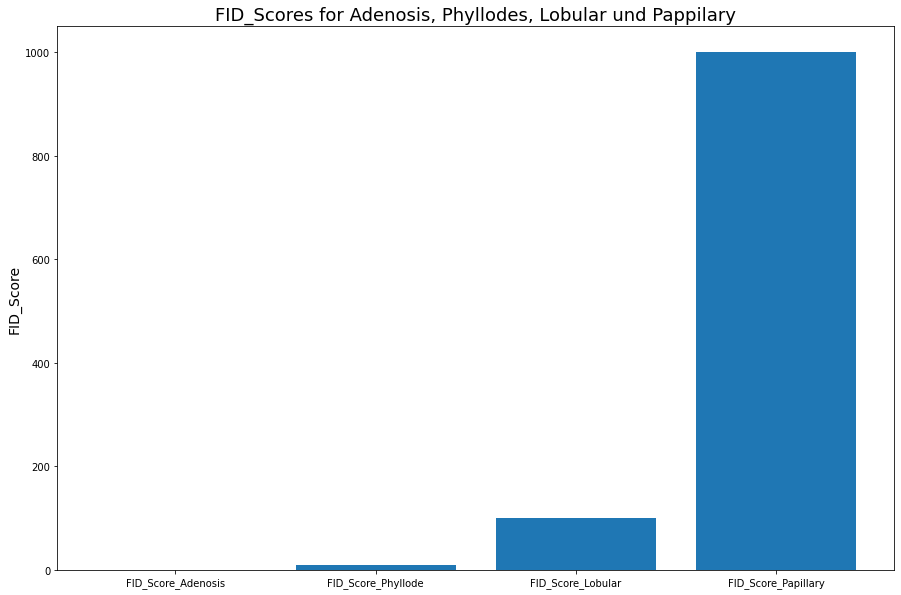

In [47]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.title('FID_Scores for Adenosis, Phyllodes, Lobular und Pappilary', fontsize = 18)
plt.ylabel('FID_Score', fontsize = 14)
plt.bar(['FID_Score_Adenosis', 'FID_Score_Phyllode', 'FID_Score_Lobular', 'FID_Score_Papillary'], [0, 10, 100, 1000])


In [ ]:
d = {'Cancer_Type': ['Adenosis', 'Phyllode', 'Lobular', 'Papillary'], 'FID_Score': [fid_adenosis, fid_phyllode, fid_lobular, fid_papillary]}
df = pd.DataFrame(data = d)
df.to_csv("FID_Scores.csv", index = False)